# Excited States via VQD

This notebook validates that:
- VQD runs for `num_states=k` states
- Works under noise

It prints:
- Lowest eigenvalues of the qubit Hamiltonian (package-provided exact diag)
- VQD final energies for states 0..k-1
- |ΔE_i| vs exact eigenvalue i

In [1]:
import numpy as np

from vqe.core import get_exact_spectrum
from vqe.vqd import run_vqd

## Configuration

In [2]:
molecule = "H2"
mapping = "jordan_wigner"
unit = "angstrom"

# k-state target
num_states = 4

# Ansatz/optimizer
ansatz_name = "StronglyEntanglingLayers"
optimizer_name = "Adam"
steps = 250
stepsize = 0.2
seed = 0

# VQD deflation schedule
beta = 10.0
beta_start = 0.0
beta_ramp = "cosine"
beta_hold_fraction = 0.1

# Noise knobs (leave at 0 for noiseless section)
depolarizing_prob = 0.00
amplitude_damping_prob = 0.00

## Exact spectrum benchmark (package-provided)

In [3]:
k_print = max(10, int(num_states))
evals = np.asarray(
    get_exact_spectrum(molecule=molecule, k=k_print, mapping=mapping, unit=unit),
    dtype=float,
)

print(f"Molecule: {molecule}")
print(f"Mapping:  {mapping}")
print(f"Lowest {k_print} exact eigenvalues (Ha):")
for i, e in enumerate(evals[:k_print]):
    print(f"#{i:>2}: {float(e): .10f}")

Molecule: H2
Mapping:  jordan_wigner
Lowest 10 exact eigenvalues (Ha):
# 0: -1.1372701749
# 1: -0.5387095807
# 2: -0.5387095807
# 3: -0.5324790143
# 4: -0.5324790143
# 5: -0.5324790143
# 6: -0.4469857253
# 7: -0.4469857253
# 8: -0.1699013991
# 9:  0.2378052722


/workspaces/Variational_Quantum_Eigensolver/vqe/core.py:1282: ComplexWarning: Casting complex values to real discards the imaginary part
  Hmat = _np.array(_qml.matrix(H), dtype=float)


## Table summary helper

In [4]:
def _summarize_vqd(result: dict, exact_evals: np.ndarray, *, label: str) -> None:
    energies = result["energies_per_state"]
    finals = [float(traj[-1]) for traj in energies]

    print("\n" + "=" * 80)
    print(label)
    print("=" * 80)

    for i, Ei in enumerate(finals):
        target = float(exact_evals[i]) if i < len(exact_evals) else float("nan")
        err = abs(Ei - target) if np.isfinite(target) else float("nan")
        print(
            f"State {i}: E_final = {Ei:+.10f} Ha   |ΔE_i| vs exact[{i}] = {err:.3e} Ha"
        )

## 1) Noiseless k-state VQD

/home/codespace/.local/lib/python3.12/site-packages/pennylane/numpy/tensor.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)


💾 Saved VQD run to /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2_vqd_stronglyentanglinglayers_4states_adam_vqd_noiseless_s0_970306e0da85.json


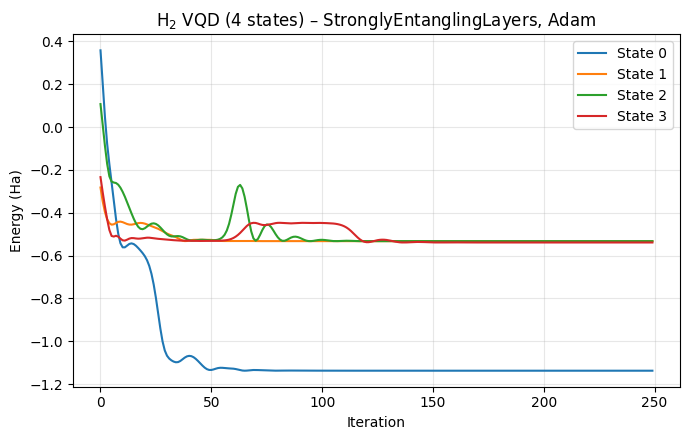

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/vqe/H2/vqd_conv_StronglyEntanglingLayers_Adam_s0.png

Noiseless VQD
State 0: E_final = -1.1372701749 Ha   |ΔE_i| vs exact[0] = 2.995e-12 Ha
State 1: E_final = -0.5324790143 Ha   |ΔE_i| vs exact[1] = 6.231e-03 Ha
State 2: E_final = -0.5324802445 Ha   |ΔE_i| vs exact[2] = 6.229e-03 Ha
State 3: E_final = -0.5387095305 Ha   |ΔE_i| vs exact[3] = 6.231e-03 Ha


In [5]:
noiseless_results = run_vqd(
    molecule=molecule,
    num_states=int(num_states),
    beta=float(beta),
    beta_start=float(beta_start),
    beta_ramp=str(beta_ramp),
    beta_hold_fraction=float(beta_hold_fraction),
    ansatz_name=str(ansatz_name),
    optimizer_name=str(optimizer_name),
    steps=int(steps),
    stepsize=float(stepsize),
    seed=int(seed),
    noisy=False,
    depolarizing_prob=0.0,
    amplitude_damping_prob=0.0,
    noise_model=None,
    plot=True,
    force=False,
    mapping=mapping,
)

_summarize_vqd(noiseless_results, evals, label="Noiseless VQD")

## 2) Noisy VQD (depolarizing + amplitude damping)

In [6]:
depolarizing_prob = 0.05
amplitude_damping_prob = 0.05

noisy_results = run_vqd(
    molecule=molecule,
    num_states=int(num_states),
    beta=float(beta),
    beta_start=float(beta_start),
    beta_ramp=str(beta_ramp),
    beta_hold_fraction=float(beta_hold_fraction),
    ansatz_name=str(ansatz_name),
    optimizer_name=str(optimizer_name),
    steps=int(steps),
    stepsize=float(stepsize),
    seed=int(seed),
    noisy=True,
    depolarizing_prob=float(depolarizing_prob),
    amplitude_damping_prob=float(amplitude_damping_prob),
    noise_model=None,
    plot=True,
    force=False,
    mapping=mapping,
)

_summarize_vqd(
    noisy_results,
    evals,
    label=f"Noisy VQD: dep={depolarizing_prob}, amp={amplitude_damping_prob}",
)

KeyboardInterrupt: 